
## Feature Creation: Combine with reference feature

The CombineWithReferenceFeature() applies combines a group of variables with a group of reference variables utilising mathematical operations ['sub', 'div','add','mul'], returning one or more additional features as a result.

For this demonstration, we use the UCI Wine Quality Dataset.

The data is publicly available on [UCI repository](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
from sklearn.pipeline import Pipeline as pipe
from sklearn.preprocessing import StandardScaler

from feature_engine.creation import RelativeFeatures
from feature_engine.creation import MathFeatures

from feature_engine.imputation import MeanMedianImputer

pd.set_option('display.max_columns', None)

In [2]:
# Read data
data = pd.read_csv('../data/winequality-red.csv', sep=';')

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


**This Data contains 11 features, all numerical, with no missing values.**

In [3]:
# Let's transform the Target, i.e Wine Quality into a binary classification problem:

bins = [0,5,10]

labels = [0, 1] # 'low'=0, 'high'=1

data['quality_range']= pd.cut(x=data['quality'], bins=bins, labels=labels)

data[['quality_range','quality']].head(5)

,quality_range,quality
0,0,5
1,0,5
2,0,5
3,1,6
4,0,5


In [4]:
data.shape

(1599, 13)

In [5]:
# drop original target

data.drop('quality', axis=1, inplace = True)

In [6]:
data.shape

(1599, 12)

### Sub and Div Combinators:

Let's create two new variables:

- non_free_sulfur_dioxide = total sulfur dioxide - free sulfur dioxide
- percentage_free_sulfur = free sulfur dioxide / total sulfur dioxide

In [7]:
import operator

In [8]:
def binary_add(x):
    return x.iloc[0] + x.iloc[1]


def binary_sub(x):
    return x.iloc[0] - x.iloc[1]


def binary_div(x):
    return x.iloc[0] / x.iloc[1]


def binary_mul(x):
    return x.iloc[0] * x.iloc[1]

In [9]:

# this transformer substracts free sulfur from total sulfur
sub_with_reference_feature = RelativeFeatures(
    variables=['total sulfur dioxide'],
    reference=['free sulfur dioxide'],
    func=['sub'],
)

# this transformer divides free sulfur by total sulfur
div_with_reference_feature = RelativeFeatures(
    variables=['free sulfur dioxide'],
    reference=['total sulfur dioxide'],
    func=['div'],
)


In [10]:
# # Create the Combinators

# sub_with_reference_feature = MathFeatures(
#     variables=['total sulfur dioxide', 'free sulfur dioxide'],
#     func=operator.sub,
#     new_variables_names=['non_free_sulfur_dioxide']
# )

# div_with_reference_feature = MathFeatures(
#     variables=['free sulfur dioxide', 'total sulfur dioxide'],
#     func=operator.truediv,
#     new_variables_names=['percentage_free_sulfur']
# )

In [11]:
# Fit the Sub Combinator on training data
sub_with_reference_feature.fit(data)

RelativeFeatures(func=['sub'], reference=['free sulfur dioxide'],
                 variables=['total sulfur dioxide'])

In [12]:
# perform the substraction
data_t = sub_with_reference_feature.transform(data)

In [13]:
# perform division
# We can combine both steps in a single call with ".fit_transform()" method
data_t = div_with_reference_feature.fit_transform(data_t)

In [14]:
# Note the additional variables at the end of the dataframe

data_t.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_range,total sulfur dioxide_sub_free sulfur dioxide,free sulfur dioxide_div_total sulfur dioxide
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,23.0,0.323529
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,42.0,0.373134
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,39.0,0.277778
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,43.0,0.283333
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,23.0,0.323529


#### Combine with more than 1 operation

We can also combine the variables with more than 1 mathematical operation. And the transformer has the option to create variable names automatically.

Here we will create the following variables:

- ratio_fixed_to_volatile_acidity = fixed acidity / volatile acidity
- total_acidity = fixed acidity + volatile acidity

In [15]:
# Create the Combinator

multiple_combinator = RelativeFeatures(
    variables=['fixed acidity'],
    reference=['volatile acidity'],
    func=['div', 'add'],
)

In [16]:
# multiple_combinator = MathFeatures(
#     variables=['fixed acidity', 'volatile acidity'],
#     func=[binary_div, binary_add],
#     new_variables_names=['ratio_fixed_to_volatile', 'total_acidity']
# )

In [17]:
# Fit the Combinator to the training data

multiple_combinator.fit(data_t)

RelativeFeatures(func=['div', 'add'], reference=['volatile acidity'],
                 variables=['fixed acidity'])

In [18]:
# Transform the data

data_t = multiple_combinator.transform(data_t)

In [19]:
# Note the additional variables at the end of the dataframe

data_t.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_range,total sulfur dioxide_sub_free sulfur dioxide,free sulfur dioxide_div_total sulfur dioxide,fixed acidity_div_volatile acidity,fixed acidity_add_volatile acidity
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,23.0,0.323529,10.571429,8.10
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,42.0,0.373134,8.863636,8.68
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,39.0,0.277778,10.263158,8.56
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1,43.0,0.283333,40.000000,11.48
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,23.0,0.323529,10.571429,8.10


### Pipeline Example

We can put all these transformations into single pipeline:

Create new variables scale features and train a Logistic Regression model to predict the wine quality range.

See more on how to use Feature-engine within Scikit-learn Pipelines in these [examples](https://github.com/solegalli/feature_engine/tree/master/examples/Pipelines)

In [20]:
X = data.drop(['quality_range'], axis=1)

y = data.quality_range

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=0,
                                                    shuffle=True,
                                                    stratify=y
                                                    )
X_train.shape, X_test.shape

((1439, 11), (160, 11))

In [21]:
value_pipe = pipe([
    
    # Create new features
    ('subtraction', RelativeFeatures(
        variables=['total sulfur dioxide'],
        reference=['free sulfur dioxide'],
        func=['sub'],
    )
    ),

    ('ratio', RelativeFeatures(
        variables=['free sulfur dioxide'],
        reference=['total sulfur dioxide'],
        func=['div'],
    )
    ),

    ('acidity', RelativeFeatures(
        variables=['fixed acidity'],
        reference=['volatile acidity'],
        func=['div', 'add'],
    )
    ),

    # scale features
    ('scaler', StandardScaler()),

    # Logistic Regression
    ('LogisticRegression', LogisticRegression())
])

In [22]:
# value_pipe = pipe([

#     # Create new features
#     ('subtraction', MathFeatures(
#         variables=['total sulfur dioxide', 'free sulfur dioxide'],
#         func=binary_sub,
#         new_variables_names=['non_free_sulfur_dioxide']
#     )
#     ),

#     ('ratio', MathFeatures(
#         variables=['free sulfur dioxide', 'total sulfur dioxide'],
#         func=binary_div,
#         new_variables_names=['percentage_free_sulfur']
#     )
#     ),

#     ('acidity', MathFeatures(
#         variables=['fixed acidity', 'volatile acidity'],
#         func=[binary_div, binary_add],
#         new_variables_names=['ratio_fixed_to_volatile', 'total_acidity']
#     )
#     ),

#     # scale features
#     ('scaler', StandardScaler()),

#     # Logistic Regression
#     ('LogisticRegression', LogisticRegression())
# ])

In [23]:
value_pipe.fit(X_train, y_train)

Pipeline(steps=[('subtraction',
                 RelativeFeatures(func=['sub'],
                                  reference=['free sulfur dioxide'],
                                  variables=['total sulfur dioxide'])),
                ('ratio',
                 RelativeFeatures(func=['div'],
                                  reference=['total sulfur dioxide'],
                                  variables=['free sulfur dioxide'])),
                ('acidity',
                 RelativeFeatures(func=['div', 'add'],
                                  reference=['volatile acidity'],
                                  variables=['fixed acidity'])),
                ('scaler', StandardScaler()),
                ('LogisticRegression', LogisticRegression())])

In [24]:
pred_train = value_pipe.predict(X_train)
pred_test = value_pipe.predict(X_test)

In [25]:
print('Logistic Regression Model train accuracy score: {}'.format(
    accuracy_score(y_train, pred_train)))

print()

print('Logistic Regression Model test accuracy score: {}'.format(
    accuracy_score(y_test, pred_test)))

Logistic Regression Model train accuracy score: 0.7477414871438499

Logistic Regression Model test accuracy score: 0.75


In [26]:
print('Logistic Regression Model test classification report: \n\n {}'.format(
    classification_report(y_test, pred_test)))

Logistic Regression Model test classification report: 

               precision    recall  f1-score   support

           0       0.73      0.73      0.73        74
           1       0.77      0.77      0.77        86

    accuracy                           0.75       160
   macro avg       0.75      0.75      0.75       160
weighted avg       0.75      0.75      0.75       160



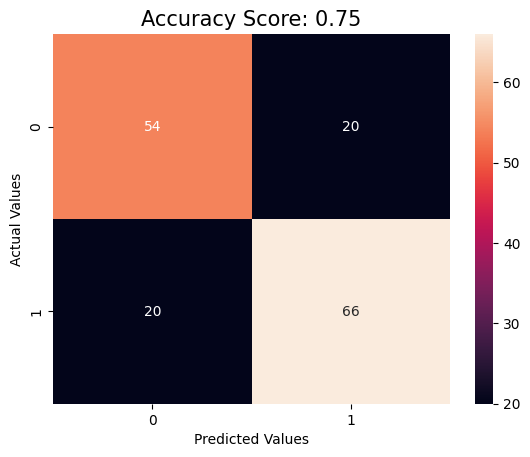

In [27]:
score = round(accuracy_score(y_test, pred_test), 3)
cm = confusion_matrix(y_test, pred_test)

sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size=15)
plt.show()

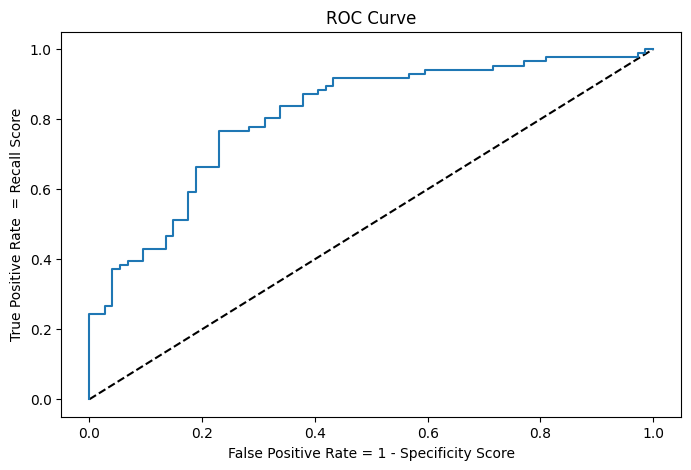

In [28]:
# Predict probabilities for the test data

probs = value_pipe.predict_proba(X_test)[:, 1]

# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate = 1 - Specificity Score')
plt.ylabel('True Positive Rate  = Recall Score')
plt.title('ROC Curve')
plt.show()